## Random walk model free

In [1]:
import numpy as np
from typing import Tuple

import pylab as pl
from scipy.sparse import linalg as slinalg
from random import choice
from numba import njit

In [2]:
class RandomWalk():
    def __init__(self, size=5):
        # definition of observables
        self.observation_size = size
        self.observation_space = list(range(size))

        # definition of the action space
        self.action_space = [-1, 1]
        
        # we always start in the middle.
        self.current_state = size//2
        self.done = False

        
    def reset(self):
        # reset the environment to the beginning
        self.current_state = self.observation_size//2
        self.done = False

    def set_state(self, state):
        assert state in self.observation_space, 'State not allowed'
        self.current_state = state
       
    def step(self, action: int) -> Tuple[int, float, bool]:
        # Takes action, updates state
        # and gives back information.

        # Check if *done* condition is satisfied.
        if self.done:
            return 0, 0, True
        
        assert action in self.action_space, 'Allowed actions are -1 (left) or 1 (right)'
        
        # Update state.
        self.current_state += action
        
        # Exit from the left: 0 reward
        reward = 0
        if self.current_state < self.observation_space[0]:
            self.done = True
        # Exit from the right: +1 reward
        elif self.current_state > self.observation_space[-1]:
            reward = 1
            self.done = True
        return self.current_state, reward, self.done

    def __repr__(self):
        return f'observation_size={self.observation_size}, current_state={self.current_state}, done={self.done}'


In [3]:
def exponential_weights(gamma: float, size: int):
    weights = np.exp(-gamma*np.arange(size))
    return weights / np.sum(weights)

def exponential_sum(x: np.ndarray, gamma: float):
    y = np.empty_like(x, dtype=float)
    y[-1] = x[-1]
    for i in range(x.shape[0]-2, -1, -1):
        y[i] = x[i] + gamma * y[i+1]
    return y

def running_mean(x:np.ndarray):
    return (np.cumsum(x, axis=0).T / np.arange(1, x.shape[0]+1)).T

In [5]:
size = 5
rw = RandomWalk(size)

In [6]:
# Optimal value
p = [0.5, 0.5]
gamma = 0.95

P = np.diag(np.ones(size-1)*p[0], -1) + np.diag(np.ones(size-1)*p[1], 1)

R = np.zeros(size)
R[-1] = p[1]

I = np.diag(np.ones(size))
opt_values = np.linalg.inv(I - gamma*P) @ R

## Digression: Multiple rewards 2D random walk

In [60]:
side = 200
side2 = side*side

centers = np.random.randint(0, side, side2//50).reshape(-1, 2)

In [76]:
@njit()
def mv(x, side=side, centers=centers):
    x = x.reshape(side, side)
    Px = np.zeros((side, side))
    N = np.zeros((side, side))

    Px[1:] += x[:-1]
    Px[:-1] += x[1:]
    Px[:, 1:] += x[:, :-1]
    Px[:, :-1] += x[:, 1:]

    N[1:] += 1
    N[:-1] += 1
    N[:, 1:] += 1
    N[:, :-1] += 1

    Px = Px/N
    for i,j in centers:
        Px[i, j] = 0
    
    return (x - 0.995*Px).ravel()

In [77]:
R = np.zeros((side, side))
for i,j in centers:
    R[i, j] = 1

R = R.ravel()

A = slinalg.LinearOperator((side2, side2), matvec=mv)
x = slinalg.cg(A, R)[0]

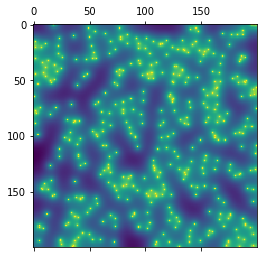

In [78]:
pl.matshow(x.reshape(side, side))

## Back to the exercise

In [7]:
def random_policy(env: RandomWalk) -> int:
    # Returns an action randomly.
    return choice(env.action_space)

In [8]:
def relative_error(approximated_values, optimal_values):
    return np.abs(approximated_values - optimal_values) / optimal_values

def L2_error(approximated_values, optimal_values):
    return np.linalg.norm(approximated_values - optimal_values, axis=1) / optimal_values.size

In [143]:
# MC estimation
def get_value_function_with_mc(environment: RandomWalk, gamma = 0.95, n_trials = 1000):
    n_states = len(environment.observation_space)
    values = np.empty((n_trials, n_states))

    for i in range(n_trials):
        for j, state in enumerate(environment.observation_space):
            environment.reset()
            environment.set_state(state)
            rewards = []
            while True:
                _, r, done = environment.step(random_policy(environment))
                rewards.append(r)
                if done:
                    break

            values[i, j] = exponential_sum(np.array(rewards), gamma)[0]

    return values

mc = get_value_function_with_mc(rw, gamma, 10000)

In [145]:
values_at_episode = running_mean(mc)

mc_error = L2_error(values_at_episode, opt_values)

In [183]:
# TD(0) estimation
n_trials = 10000
lr = 5

states = rw.observation_space
state_occurrences = {s: 0 for s in states}
value_function = {s: 0 for s in states}
value_function[-1] = 0
value_function[size] = 0

value_td_0 = np.empty((n_trials, len(rw.observation_space)))

for i in range(n_trials):
    rw.reset()
    while not rw.done:
        s0 = rw.current_state
        s, r, done = rw.step(random_policy(rw))
        N = state_occurrences[s0]
        delta = r + gamma*value_function[s] - value_function[s0]
        value_function[s0] += (lr * delta) / (N+1)
        state_occurrences[s0] += 1
    

    value_td_0[i] = np.array([v for k, v in value_function.items() if k in range(size)])

td_0_error = L2_error(value_td_0, opt_values)

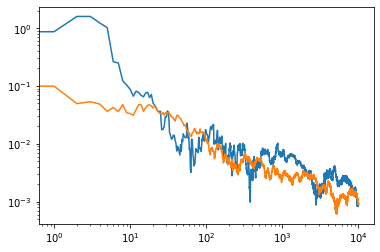

In [184]:
pl.plot(td_0_error)
pl.plot(mc_error)
pl.yscale("log")
pl.xscale("log")